# Evaluate the impact of enviromental variables on TC prediction
 -  compare monthly climatology of relevant variables between S2S and obseravtoins
 -  compare GPI
 -  compare GPI by replacing each term with observation
 -  evaluate ensemble spread

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import hvplot.xarray
import matplotlib
import matplotlib.pyplot as plt
import time
import dask
import warnings
warnings.filterwarnings('ignore')

In [2]:
from geocat.viz import util as gvutil
from geocat.viz import cmaps as gvcmaps

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

## Set up: define plotting functions

In [4]:
def compare_climatology_bylead(var,basin):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    fig.tight_layout(pad=4)
    basin_str=['AT','EP','NI','NWP','SH']

    if (basin==0):
        var = var.sel(lat =slice(5,30),lon=slice(280,360)).mean(('lat','lon'))
    elif (basin==1):
        var = var.sel(lat=slice(5,30),lon=slice(230,280)).mean(('lat','lon'))
    elif (basin==2):
        var = var.sel(lat=slice(5,20),lon=slice(80,100)).mean(('lat','lon'))
    elif (basin==3):
        var = var.sel(lat=slice(5,30),lon=slice(110,180)).mean(('lat','lon'))
    elif (basin==4):
        var = var.sel(lat=slice(-30,-5),lon=slice(40,280)).mean(('lat','lon'))

    # week1
    for iw in np.arange(0,6):
        var[iw].plot(ax = ax1,label ='week '+(iw+1).astype(str),linewidth = 2)

    ax1.plot(np.arange(1,13),np.zeros(12),color='black',linestyle='--')

    
    ax1.set_xlim(1,12)
    ax1.set_title(var.name+' bias, basin ='+basin_str[basin])
    ax1.set_xlabel("month",fontsize=12)
    ax1.set_xticks(np.arange(1,13))

# plt.subplots_adjust(top=0.85)
    ax1.legend()


    plt.show()

In [5]:
## define gpi plotting funcition
def var_plot_panels(variable, i,j, levels, colormap, title,colorbar):
    ax1= fig.add_subplot(spec[i,j], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    if colorbar==True:
        plt.colorbar(contour,
                     ax=ax1,
                     ticks=np.arange(0,20),
                     orientation='horizontal',
                     pad=0.075,
                     drawedges=True,
                     shrink=0.7)

    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-110, 170),
                                 ylim=(0, 40),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


In [6]:
## define gpi plotting funcition
def var_plot_panels_winter(variable, i,j, levels, colormap, title,colorbar):
    ax1= fig.add_subplot(spec[i,j], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    if colorbar==True:
        plt.colorbar(contour,
                     ax=ax1,
                     ticks=np.arange(0,20),
                     orientation='horizontal',
                     pad=0.075,
                     drawedges=True,
                     shrink=0.7)

    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-150, 130),
                                 ylim=(-40, 0),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


## 1. read in observational climatology from jra55: PSL, vo850, rh700 and shear, SST from oisst,


In [7]:
dsst = xr.open_dataset('/glade/work/huili7/S2S/clim_data/oisst_climatology_2002-2019.nc')
sst = dsst.t

ds_ps = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_ps_2002-2019.nc')
ps = ds_ps.sp


In [8]:
omega = 7.2921 * 1e-5 #rad/s
dsv = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv850_2002-2019.nc')
vor = dsv.vo + 2 * omega * np.sin(np.deg2rad(dsv.latitude)) 
vor_rel = dsv.vo
u850 = dsv.u
v850 = dsv.v

dsv2 = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv200_2002-2019.nc')
u200 = dsv2.u
v200 = dsv2.v

dsr = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_rh700_2002-2019.nc')
rh700 = dsr.r

dsmask = xr.open_dataset('/gpfs/fs1/collections/rda/data/ds277.0/climatology/lsmask.nc')
lsm=dsmask.mask

dvmax = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra_pi_VMAX.nc')
vmax = dvmax.VMAX

In [9]:
shear = np.sqrt((u200 - u850)**2 + (v200-v850)**2) 

In [10]:
lsm1 = lsm.rename({'lat':'latitude'})
lsm2 = lsm1.rename({'lon':'longitude'})
sst = sst.where(lsm2[0]==1)
sst = sst - 273.15



## read in ERAI data

In [12]:
omega = 7.2921 * 1e-5 #rad/s

# dsst_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_sst_2002-2018.nc')
# sst_e  = dsst_e.sst

# dps_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_psl_2002-2018.nc')
# psl_e  = dps_e.msl

# dsvr_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_vr850_2002-2018.nc')
# vor_e = dsvr_e.vo + 2 * omega * np.sin(np.deg2rad(dsvr_e.latitude)) 

# dsv_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_uv850_2002-2018.nc')
# u850_e = dsv_e.u
# v850_e = dsv_e.v

# dsv2_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_uv200_2002-2018.nc')
# u200_e = dsv2_e.u
# v200_e = dsv2_e.v

# dsr_e = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_climo_rh700_2002-2018.nc')
# rh700_e = dsr_e.r

# #dsmask = xr.open_dataset('/gpfs/fs1/collections/rda/data/ds277.0/climatology/lsmask.nc')
# #lsm=dsmask.mask

# shear_e = np.sqrt((u200_e - u850_e)**2 + (v200_e-v850_e)**2) 

## 2. Read in S2S climatology

In [11]:
sst_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    dsst = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_sst_week'+week+'_monclim.nc')
    sst_list.append(dsst.SST)
S2S_sst = xr.concat(sst_list,dim='week')
S2S_sst['week'] = np.arange(1,7)

In [12]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_psl_week'+week+'_monclim.nc')
    var_list.append(ds.PSL)
S2S_psl = xr.concat(var_list,dim='week')
S2S_psl['week'] = np.arange(1,7)

In [13]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_ua850_week'+week+'_monclim.nc')
    var_list.append(ds.ua_850)
S2S_ua850 = xr.concat(var_list,dim='week')
S2S_ua850['week'] = np.arange(1,7)

In [14]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_va850_week'+week+'_monclim.nc')
    var_list.append(ds.va_850)
S2S_va850 = xr.concat(var_list,dim='week')
S2S_va850['week'] = np.arange(1,7)

In [15]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_ua200_week'+week+'_monclim.nc')
    var_list.append(ds.ua_200)
S2S_ua200 = xr.concat(var_list,dim='week')
S2S_ua200['week'] = np.arange(1,7)

In [16]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_va200_week'+week+'_monclim.nc')
    var_list.append(ds.va_200)
S2S_va200 = xr.concat(var_list,dim='week')
S2S_va200['week'] = np.arange(1,7)

In [17]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_rh700_week'+week+'_monclim.nc')
    var_list.append(ds.RELHUM)
S2S_rh700 = xr.concat(var_list,dim='week')
S2S_rh700['week'] = np.arange(1,7)

In [18]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_vor850_week'+week+'_monclim.nc')
    var_list.append(ds.vo)
S2S_vo850_raw = xr.concat(var_list,dim='week')
S2S_vo850_raw['week'] = np.arange(1,7)

In [19]:
# get relative vorticity
coriolis = 2* omega * np.sin(np.deg2rad(S2S_vo850_raw.lat)) 
a1, F = xr.broadcast(S2S_vo850_raw, coriolis)



In [20]:
S2S_vorel850_raw = S2S_vo850_raw.copy(data = (S2S_vo850_raw.data - F.data))

In [22]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_pi_VMAX_week'+week+'.nc')
    var_list.append(ds.VMAX)
S2S_vmax = xr.concat(var_list,dim='week')
S2S_vmax['week'] = np.arange(1,7)

In [23]:
S2S_shear_raw = np.sqrt((S2S_ua200 - S2S_ua850)**2 + (S2S_va200-S2S_va850)**2) 

In [24]:
S2S_shear_raw

<xarray.DataArray (week: 6, month: 12, member: 10, lat: 181, lon: 360)>
array([[[[[ 4.789222  ,  4.7890387 ,  4.7889485 , ...,  4.7889495 ,
            4.7889485 ,  4.78904   ],
          [ 4.99594   ,  4.988256  ,  4.980027  , ...,  5.0154324 ,
            5.0089254 ,  5.002481  ],
          [ 5.623111  ,  5.6167397 ,  5.609249  , ...,  5.6338315 ,
            5.6310906 ,  5.627787  ],
          ...,
          [ 3.8972087 ,  3.9051733 ,  3.912605  , ...,  3.8697793 ,
            3.8793366 ,  3.8885021 ],
          [ 3.2239382 ,  3.228183  ,  3.232252  , ...,  3.2099047 ,
            3.2147408 ,  3.219446  ],
          [ 2.6626353 ,  2.6625705 ,  2.6625288 , ...,  2.6625147 ,
            2.6625125 ,  2.6625597 ]],

         [[ 4.386286  ,  4.386119  ,  4.386036  , ...,  4.3860354 ,
            4.3860354 ,  4.386119  ],
          [ 4.653543  ,  4.6458554 ,  4.6373897 , ...,  4.674686  ,
            4.6677675 ,  4.660826  ],
          [ 5.320128  ,  5.3124456 ,  5.303837  , ...,  5.335817  ,
            5.3318458 ,  5.326889  ],
...
          [ 3.2280161 ,  3.2373946 ,  3.2463067 , ...,  3.1954393 ,
            3.206793  ,  3.2176442 ],
          [ 2.4158525 ,  2.4187622 ,  2.4214845 , ...,  2.404706  ,
            2.4086952 ,  2.4124205 ],
          [ 1.8978298 ,  1.897757  ,  1.8977208 , ...,  1.8977236 ,
            1.8977214 ,  1.8977572 ]],

         [[ 5.5498753 ,  5.5496655 ,  5.5495596 , ...,  5.549562  ,
            5.5495605 ,  5.549666  ],
          [ 5.958294  ,  5.9475813 ,  5.936183  , ...,  5.987681  ,
            5.9779034 ,  5.968322  ],
          [ 6.6416183 ,  6.6257315 ,  6.6089015 , ...,  6.682459  ,
            6.6700463 ,  6.6563983 ],
          ...,
          [ 3.45762   ,  3.462244  ,  3.4665575 , ...,  3.4401352 ,
            3.4463587 ,  3.4521773 ],
          [ 2.656649  ,  2.6587596 ,  2.6605966 , ...,  2.648066  ,
            2.6511655 ,  2.653998  ],
          [ 1.9577208 ,  1.9576474 ,  1.9576082 , ...,  1.9576099 ,
            1.9576099 ,  1.9576467 ]]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * week     (week) int64 1 2 3 4 5 6

###  change SST unit

In [24]:
#sst_e = sst_e - 273.15

In [25]:
S2S_sst = S2S_sst.where(S2S_sst>0)
S2S_sst = S2S_sst -273.15

### regrid erai observational data

In [26]:
# sste_regrid = sst_e.interp(latitude=S2S_sst.lat, longitude = S2S_sst.lon, method='linear')
# pse_regrid = psl_e.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')
# sheare_regrid = shear_e.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')
# voe_regrid = vor_e.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')
# rhe_regrid = rh700_e.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')


### regrid jra55 observtional data

In [26]:
ssto_regrid = sst.interp(latitude=S2S_sst.lat, longitude = S2S_sst.lon, method='linear')

# regrid observational ps
pso_regrid = ps.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')


# regrid model observational wind shear
shearo_regrid = shear.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')

# regrid obs 850hpa vorticity
vo_regrid = vor.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')
vorel_regrid = vor_rel.interp(latitude = S2S_sst.lat, longitude = S2S_sst.lon, method='linear')
# regrid relative humidity at 700 hPa
rh700o_regrid = rh700.interp(latitude=S2S_sst.lat,longitude=S2S_sst.lon, method='linear')
vmaxo_regrid = vmax.interp(latitude=S2S_sst.lat,longitude = S2S_sst.lon, method='linear')

### regrid S2S shear and vorticity data, because they are on the different grid who knows why

In [27]:
S2S_shear= S2S_shear_raw.interp(lat = S2S_sst.lat,lon = S2S_sst.lon, method='linear')
S2S_vo850= S2S_vo850_raw.interp(lat = S2S_sst.lat,lon = S2S_sst.lon, method='linear')
S2S_vorel850 = S2S_vorel850_raw.interp(lat = S2S_sst.lat,lon = S2S_sst.lon, method='linear')

## 3. diagnostics of climatology

In [29]:
# differences between S2S and erai
# sst_diff =S2S_sst.isel(member=0).copy(data=S2S_sst.mean('member').data - sste_regrid.data)

# ps_diff = S2S_psl.isel(member=0).copy(data=S2S_psl.mean('member').data-pse_regrid.data)

# shear_diff = S2S_shear.isel(member=0).copy(data=S2S_shear.mean('member').data -sheare_regrid.data)

# vo_diff = S2S_vo850.isel(member=0).copy(data=S2S_vo850.mean('member').data - voe_regrid.data)

# rh_diff = S2S_rh700.isel(member=0).copy(data = S2S_rh700.mean('member').data - rhe_regrid.data)

In [29]:
# differences between s2s and observations
sst_diff =S2S_sst.isel(member=0).copy(data=S2S_sst.mean('member').data - ssto_regrid.data)
ps_diff = S2S_psl.isel(member=0).copy(data=S2S_psl.mean('member').data-pso_regrid.data)
shear_diff = S2S_shear.isel(member=0).copy(data=S2S_shear.mean('member').data -shearo_regrid.data)
vo_diff = S2S_vo850.isel(member=0).copy(data=S2S_vo850.mean('member').data - vo_regrid.data)
vorel_diff = S2S_vorel850.isel(member=0).copy(data=S2S_vorel850.mean('member').data - vorel_regrid.data)
rh_diff = S2S_rh700.isel(member=0).copy(data = S2S_rh700.mean('member').data - rh700o_regrid.data)
vmax_diff = S2S_vmax.isel(member=0).copy(data = S2S_vmax.mean('member').data - vmaxo_regrid.data)

In [30]:
ps_diff = ps_diff * 0.01
ps_diff = ps_diff.where(np.isfinite(sst_diff))

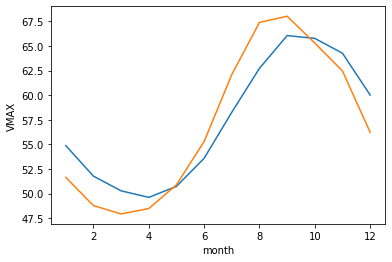

In [31]:
S2S_vmax.sel(week=3,lat=slice(0,40), lon=slice(120,200)).mean(('member','lat','lon')).plot()
vmaxo_regrid.sel(lat=slice(0,40), lon=slice(120,200)).mean(('lat','lon')).plot()

### 3.1 compare seasonal cycle by lead

These figures show biases in seasnoal cycle at each lead week. 

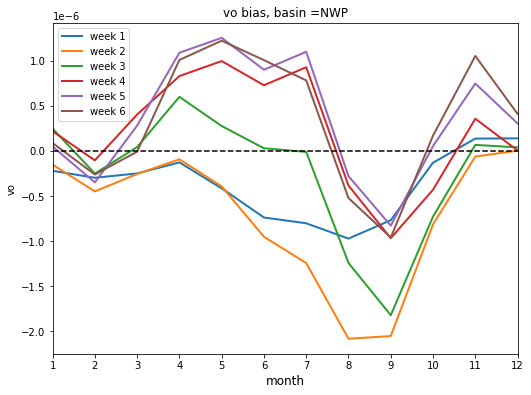

In [33]:
compare_climatology_bylead(vorel_diff, 3)

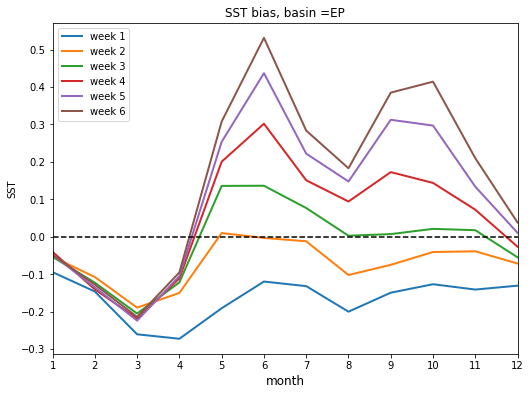

In [33]:
compare_climatology_bylead(sst_diff, 1)

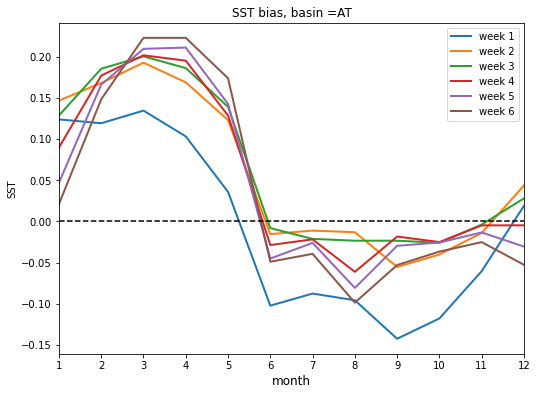

In [34]:
compare_climatology_bylead(sst_diff,0)

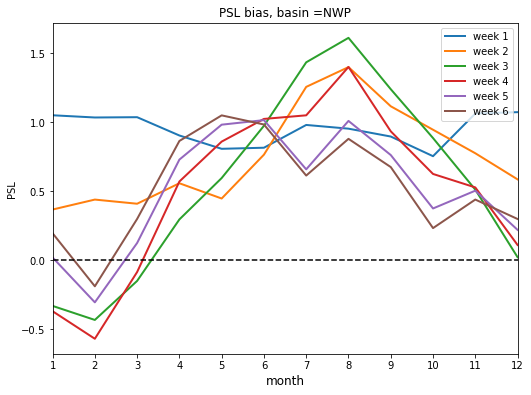

In [35]:
compare_climatology_bylead(ps_diff, 3)

**note**:\
ok, this is weired. cold SST bias in Jan-Aug, warm bias in Aug- Dec

### 3.2 compare large-scale variables during TC season

In [34]:
sst_n_summer = sst_diff.sel(month=slice(5,10)).mean('month')
ps_n_summer = ps_diff.sel(month=slice(5,10)).mean('month')
shear_n_summer = shear_diff.sel(month=slice(5,10)).mean('month')
rh_n_summer = rh_diff.sel(month=slice(5,10)).mean('month')
vo_n_summer = vo_diff.sel(month=slice(5,10)).mean('month')
vorel_n_summer = vorel_diff.sel(month=slice(5,10)).mean('month')
vmax_n_summer = vmax_diff.sel(month=slice(5,10)).mean('month')

In [35]:
sst_n_winter = sst_diff.sel(month=[1,2,3,4,12]).mean('month')
ps_n_winter = ps_diff.sel(month=[1,2,3,4,12]).mean('month')
shear_n_winter = shear_diff.sel(month=[1,2,3,4,12]).mean('month')
rh_n_winter = rh_diff.sel(month=[1,2,3,4,12]).mean('month')
vo_n_winter = vo_diff.sel(month=[1,2,3,4,12]).mean('month')
vorel_n_winter = vorel_diff.sel(month=[1,2,3,4,12]).mean('month')
vmax_n_winter = vmax_diff.sel(month=[1,2,3,4,12]).mean('month')


In [36]:
sst_n_summer_diff = sst_n_summer.copy(data=sst_n_summer.data - sst_n_summer[0].data)
ps_n_summer_diff = ps_n_summer.copy(data=ps_n_summer.data - ps_n_summer[0].data)
shear_n_summer_diff = shear_n_summer.copy(data=shear_n_summer.data - shear_n_summer[0].data)
rh_n_summer_diff = rh_n_summer.copy(data=rh_n_summer.data - rh_n_summer[0].data)
vo_n_summer_diff = vo_n_summer.copy(data=vo_n_summer.data - vo_n_summer[0].data)
vmax_n_summer_diff = vmax_n_summer.copy(data=vmax_n_summer.data - vmax_n_summer[0].data)


In [37]:
sst_n_winter_diff = sst_n_winter.copy(data=sst_n_winter.data - sst_n_winter[0].data)
ps_n_winter_diff = ps_n_winter.copy(data=ps_n_winter.data - ps_n_winter[0].data)
shear_n_winter_diff = shear_n_winter.copy(data=shear_n_winter.data - shear_n_winter[0].data)
rh_n_winter_diff = rh_n_winter.copy(data=rh_n_winter.data - rh_n_winter[0].data)
vo_n_winter_diff = vo_n_winter.copy(data=vo_n_winter.data - vo_n_winter[0].data)
vmax_n_winter_diff = vmax_n_winter.copy(data=vmax_n_winter.data - vmax_n_winter[0].data)


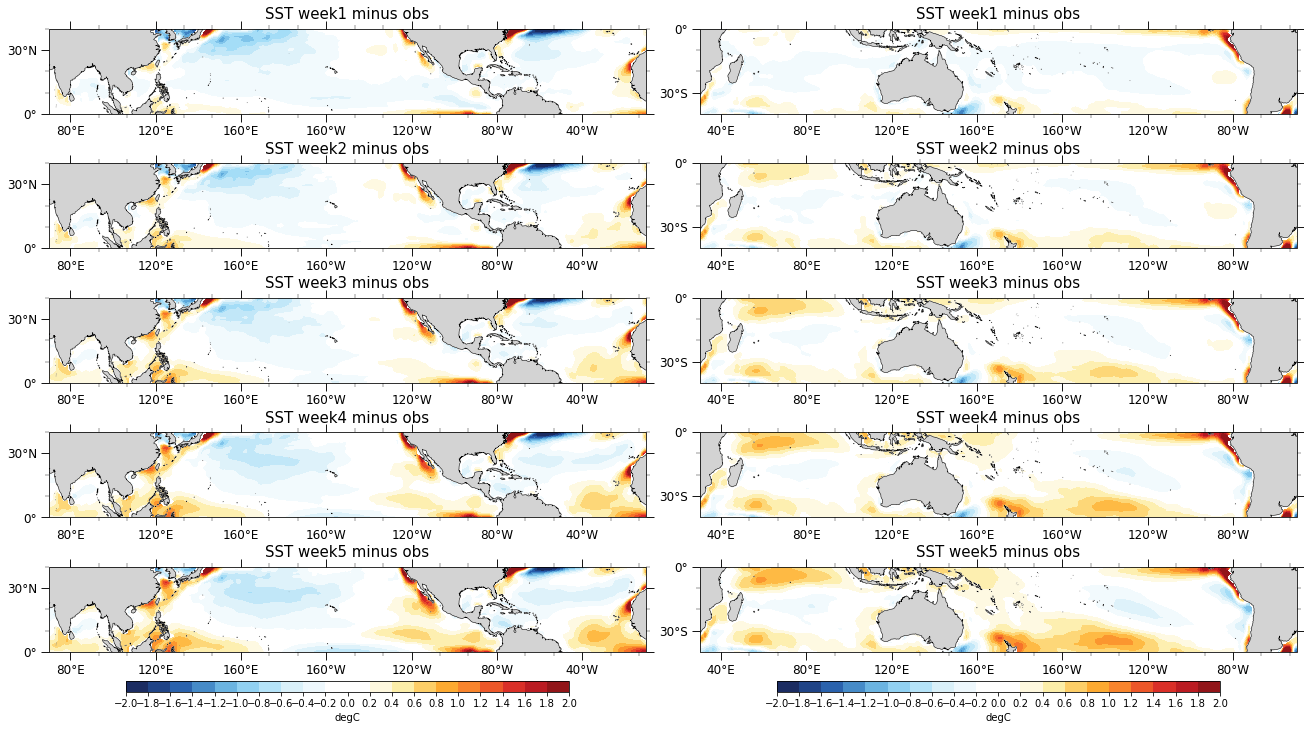

In [38]:
levels=np.linspace(-2,2, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot SST
var_plot_panels(sst_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"SST week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(sst_n_summer[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"SST week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = np.linspace(-2,2,21).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('degC')


# plot winter
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(sst_n_winter[0],0,1,levels,cmap,"SST week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels_winter(sst_n_winter[i],i,1,levels,cmap,"SST week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('degC')




#plt.show()
plt.savefig('SST_bias_climo.pdf')

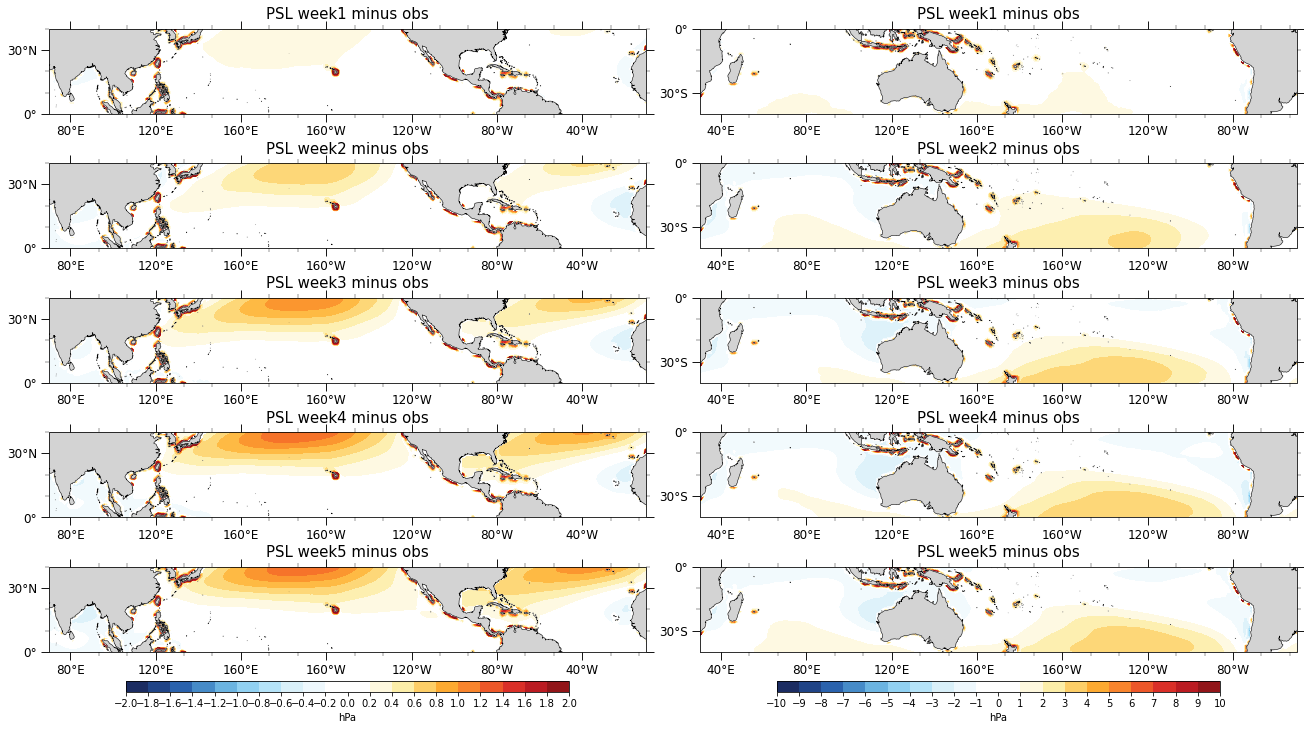

In [49]:
levels=np.linspace(-10,10, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot PSL NH
var_plot_panels(ps_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"PSL week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(ps_n_summer[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"PSL week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = np.linspace(-2,2,21).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('hPa')




# plot psl
levels=np.linspace(-10,10, 21)
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(ps_n_winter[0],0,1,levels,cmap,"PSL week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels_winter(ps_n_winter[i],i,1,levels,cmap,"PSL week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('hPa')

#plt.show()
plt.savefig('psl_bias_climo.pdf')

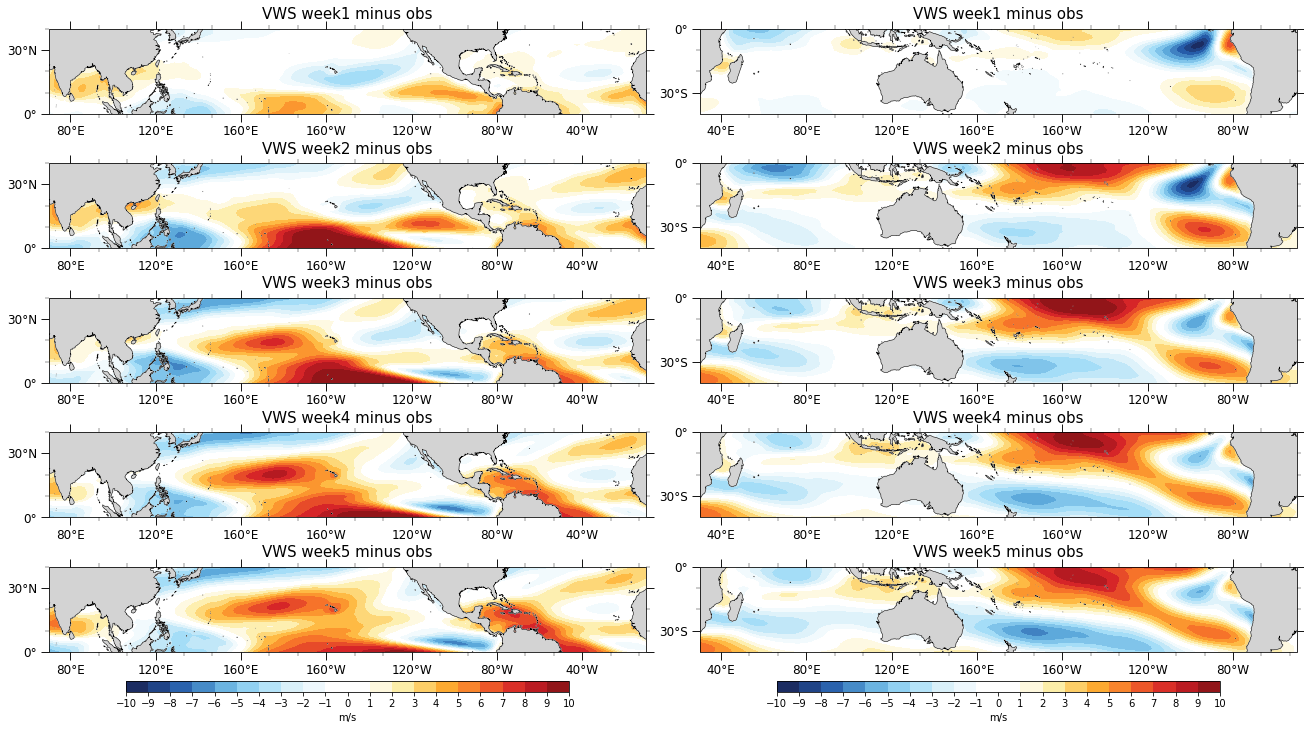

In [50]:
levels=np.linspace(-10,10, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels(shear_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"VWS week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(shear_n_summer[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"VWS week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




# plot winter

cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(shear_n_winter[0],0,1,levels,cmap,"VWS week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels_winter(shear_n_winter[i],i,1,levels,cmap,"VWS week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('m/s')

#plt.show()
plt.savefig('VWS_bias_climo.pdf')

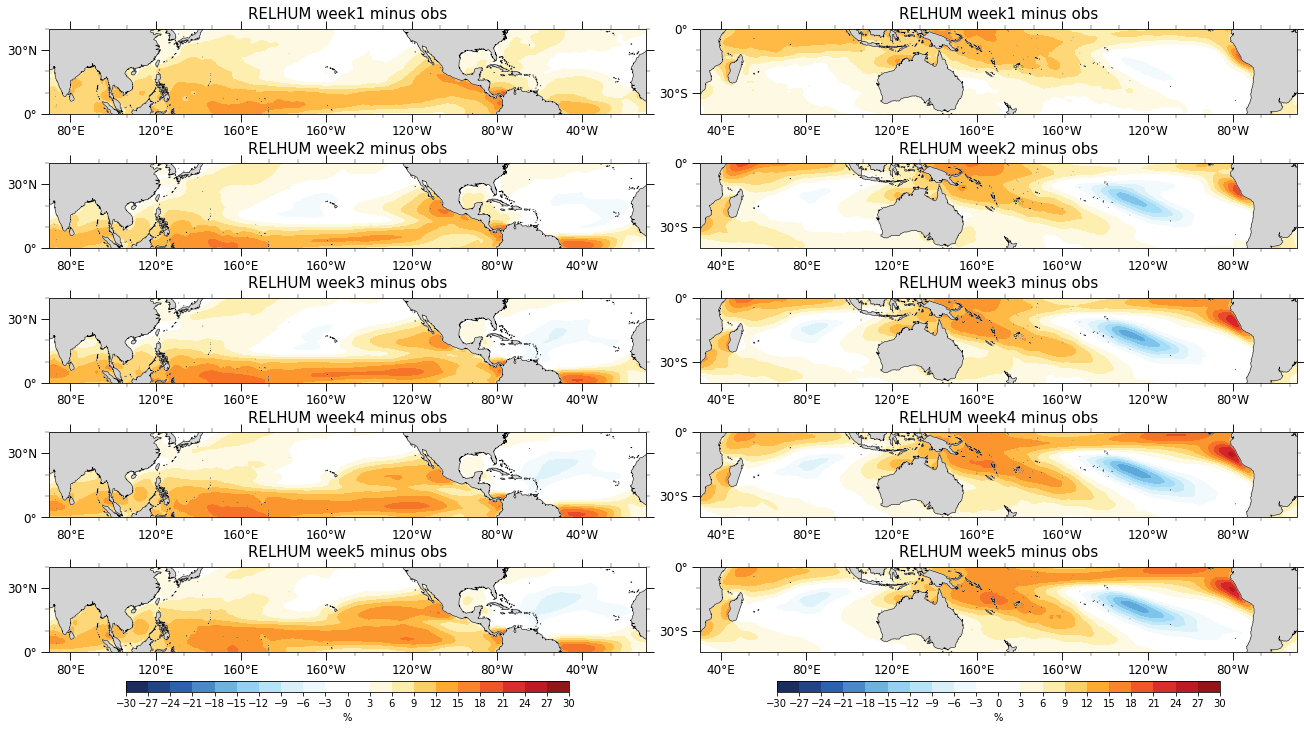

In [52]:
levels=np.linspace(-30,30, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot relhum
var_plot_panels(rh_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"RELHUM week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(rh_n_summer[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"RELHUM week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('%')




# plot rh700

cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(rh_n_winter[0],0,1,levels,cmap,"RELHUM week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels_winter(rh_n_winter[i],i,1,levels,cmap,"RELHUM week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('%')

#plt.show()
plt.savefig('relhum_bias_climo.pdf')

In [ ]:
levels=np.linspace(-1,1, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels(1e4*vorel_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"850hPa vort week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(1e4*vorel_n_summer[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"850hPa vort week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('1e-5 1/s')



# winter
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(1e5*vorel_n_winter[0],0,1,levels,cmap,"850 hPa vort week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels_winter(1e5*vorel_n_winter[i],i,1,levels,cmap,"850 hPa vort week"+(i+1).astype(str)+" minus obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('1e-5 1/s')

plt.savefig('vor_bias_climo.pdf')

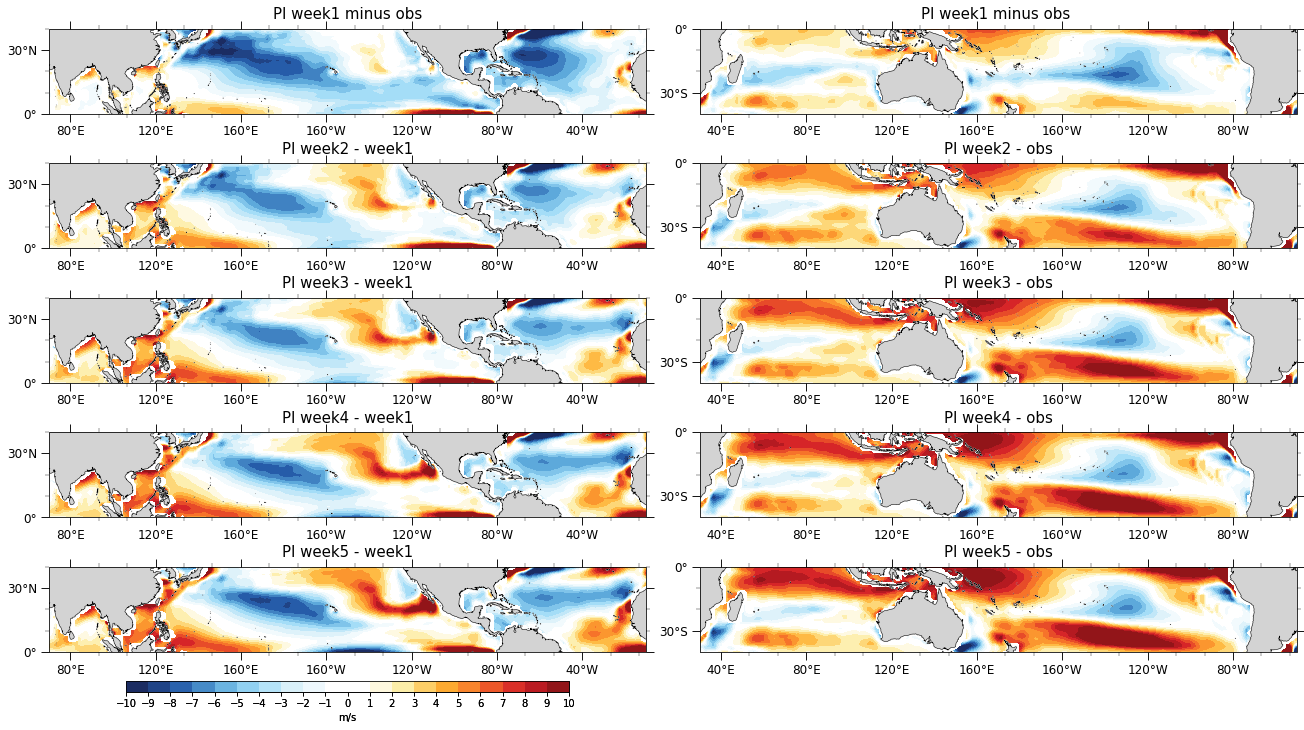

In [58]:
levels=np.linspace(-10,10, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot wind shear
var_plot_panels(vmax_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"PI week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(vmax_n_summer[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"PI week"+(i+1).astype(str)+" - week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

# plot vmax
levels=np.linspace(-10,10, 21)
var_plot_panels_winter(vmax_n_winter[0],0,1,levels,gvcmaps.BlueWhiteOrangeRed,"PI week1 minus obs ", False)

for i in np.arange(1,5):
    var_plot_panels_winter(vmax_n_winter[i],i,1,levels,gvcmaps.BlueWhiteOrangeRed,"PI week"+(i+1).astype(str)+" - obs", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')
plt.savefig('pi_bias_climo.pdf')




## 4. GPI comparisons

In [7]:
dsg = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra_gpi_2002-2019.nc')
gpi_jra = dsg.gpi

In [8]:
gpi_jra

<xarray.DataArray 'gpi' (month: 12, latitude: 145, longitude: 288)>
[501120 values with dtype=float64]
Coordinates:
    number     int64 ...
    step       timedelta64[ns] ...
  * latitude   (latitude) float64 90.0 88.75 87.5 86.25 ... -87.5 -88.75 -90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [15]:
dsg1 = xr.open_dataset('/glade/work/huili7/S2S/clim_data/erai_gpi_2002-2018.nc')
gpi_era = dsg1.gpi

In [16]:
gpi_era

<xarray.DataArray 'gpi' (month: 12, latitude: 256, longitude: 512)>
[1572864 values with dtype=float64]
Coordinates:
    number     int64 ...
    step       timedelta64[ns] ...
  * latitude   (latitude) float64 89.46 88.77 88.07 ... -88.07 -88.77 -89.46
  * longitude  (longitude) float64 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
dsg_w1 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week1.nc')
gpi_w1 = dsg_w1.gpi

dsg_w2 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week2.nc')
gpi_w2 = dsg_w2.gpi

dsg_w3 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week3.nc')
gpi_w3 = dsg_w3.gpi

dsg_w4 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week4.nc')
gpi_w4 = dsg_w4.gpi

dsg_w5 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week5.nc')
gpi_w5 = dsg_w5.gpi

dsg_w6 = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_gpi_week6.nc')
gpi_w6 = dsg_w6.gpi

In [10]:
gpi_weeks = xr.concat([gpi_w1, gpi_w2, gpi_w3, gpi_w4, gpi_w5, gpi_w6],dim='week')

In [11]:
gpi_weeks['week'] = np.arange(1,7)

In [92]:
gpi_weeks

<xarray.DataArray 'gpi' (week: 6, month: 12, member: 10, lat: 192, lon: 288)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev_p    float64 700.0
  * week     (week) int64 1 2 3 4 5 6

### regrid obs gpi to model grid

In [12]:
gpi_jra_regrid = gpi_jra.interp(latitude = dsg_w1.lat, longitude=dsg_w1.lon, method='linear')

In [18]:
gpi_era_regrid = gpi_era.interp(latitude = dsg_w1.lat, longitude = dsg_w1.lon, method='linear')

In [55]:
gpi_obs_diff = gpi_era_regrid.copy(data=gpi_era_regrid.data - gpi_jra_regrid.data)

In [13]:
gpi_summer = gpi_weeks.sel(month=slice(6,10)).mean('month')
gpi_winter = gpi_weeks.sel(month=[1,2,3,4,11,12]).mean('month')

In [19]:
gpi_era_summer = gpi_era_regrid.sel(month=slice(6,10)).mean('month')
gpi_era_winter = gpi_era_regrid.sel(month=[1,2,3,4,11,12]).mean('month')
gpi_jra_summer =  gpi_jra_regrid.sel(month=slice(6,10)).mean('month')
gpi_jra_winter = gpi_jra_regrid.sel(month=[1,2,3,4,11,12]).mean('month')

In [20]:
gpi_summer_diff = gpi_summer.copy(data=gpi_summer.data - gpi_jra_summer.data)
gpi_winter_diff = gpi_winter.copy(data=gpi_winter.data - gpi_jra_winter.data)

In [21]:
gpi_summer_diffm = gpi_summer_diff.copy(data=gpi_summer_diff.data - gpi_summer_diff.isel(week=0).data)
gpi_winter_diffm = gpi_winter_diff.copy(data=gpi_winter_diff.data - gpi_winter_diff.isel(week=0).data)

In [22]:
gpi_month_diff = gpi_weeks -  gpi_jra_regrid

### 4.1 GPI seasonala cycle bias by lead

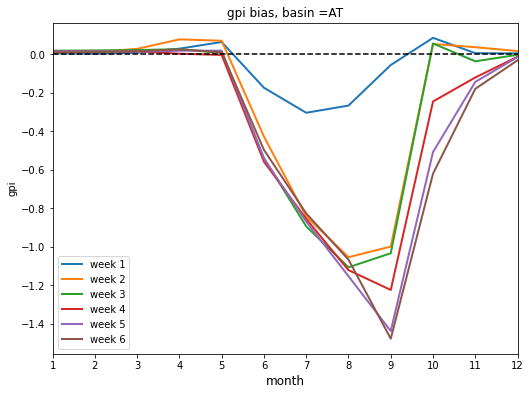

In [83]:
compare_climatology_bylead(gpi_month_diff.mean('member'),0)

### 4.2 GPI bias patterns by lead

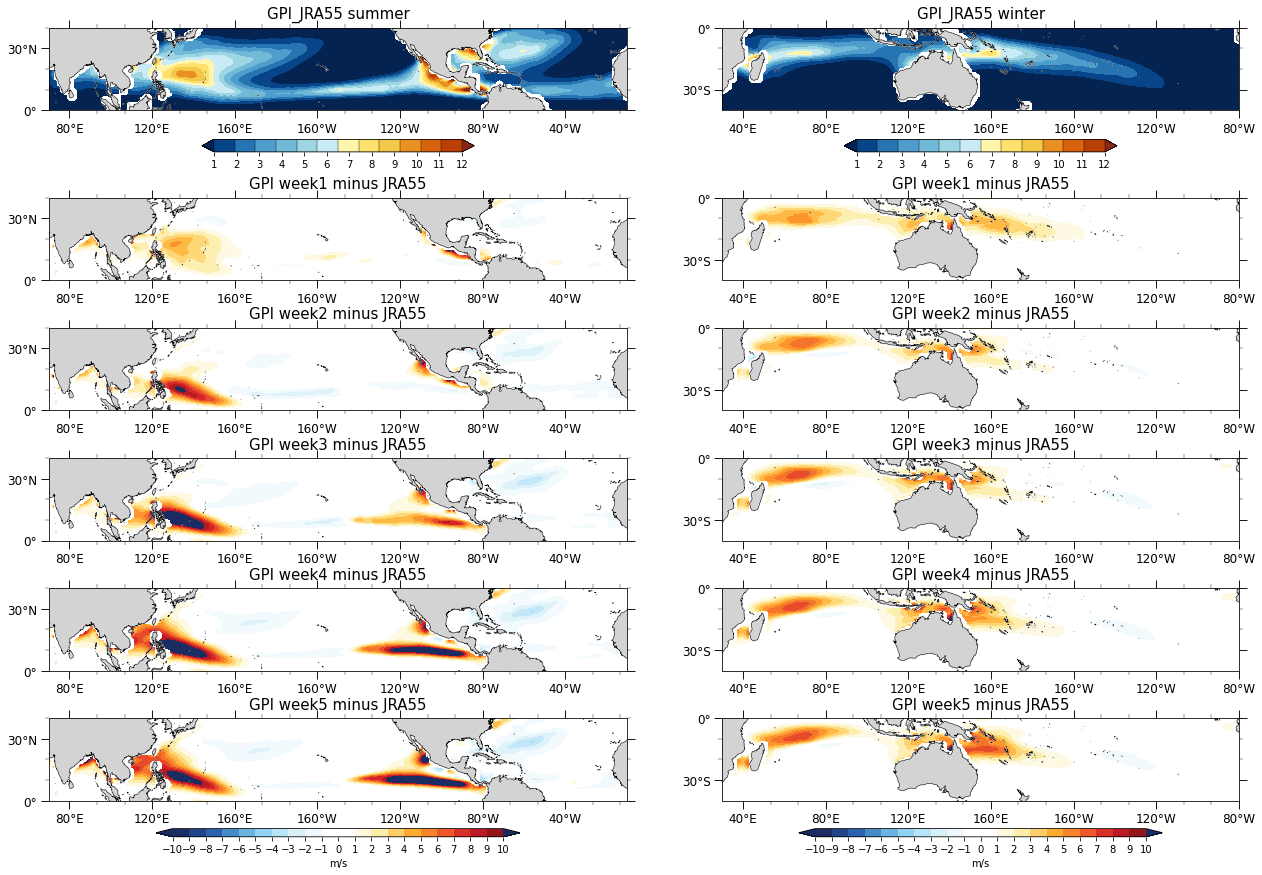

In [46]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 7,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)
cmap=gvcmaps.BlueWhiteOrangeRed

# plot observations
var_plot_panels(gpi_jra_summer,0,0,levels,gvcmaps.BlueYellowRed,"GPI_JRA55 summer", True)
var_plot_panels(gpi_summer_diff.mean('member').isel(week=0),1,0,levels2,cmap,"GPI week1 minus JRA55", False)

for i in np.arange(1,5):
    var_plot_panels(gpi_summer_diff.mean('member')[i],i+1,0,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" minus JRA55", False)

# add common colarbar
ax= fig.add_subplot(spec[6,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter
# plot observations
var_plot_panels_winter(gpi_jra_winter,0,1,levels,gvcmaps.BlueYellowRed,"GPI_JRA55 winter", True)
var_plot_panels_winter(gpi_winter_diff.mean('member').isel(week=0),1,1,levels2,cmap,"GPI week1 minus JRA55", False)

for i in np.arange(1,5):
    var_plot_panels_winter(gpi_winter_diff.mean('member')[i],i+1,1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" minus JRA55", False)

# add common colarbar
ax= fig.add_subplot(spec[6,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')
plt.savefig('GPI_pattern_compare_obs.pdf')



## 5. contribution of each environmental variable to GPI differences

- calculate GPI by replacing certain variable with observational data

In [63]:
# get observational terms
# regrid observational ps
t_vor_o = np.abs(1e5 * vo_regrid)**(3/2)  # s**-3/2
t_rh_o =  (rh700o_regrid / 50)**3 
t_pi_o =  (vmaxo_regrid / 70)**3   # m3 s-3
t_shear_o = (1 + 0.1 * shearo_regrid) ** -2    # m-2 s2

In [64]:
# get model terms
t_vor = S2S_vo850.copy(data=np.abs(1e5 * S2S_vo850)**(3/2))  # s**-3/2
t_rh =  S2S_rh700.copy(data=(S2S_rh700 / 50)**3)
t_pi =  S2S_vmax.copy(data=(S2S_vmax / 70)**3)   # m3 s-3
t_shear = S2S_shear.copy(data=(1 + 0.1 * S2S_shear) ** -2)    # m-2 s2



### 5.1 replace one of the terms in S2S gpi with observations and keep the rest the same 

In [65]:
# now get gpi with observational terms
gpi_vor = (t_rh * t_vor_o  * t_pi * t_shear).rename('gpi_vor')
gpi_rh  = (t_vor * t_rh_o * t_pi * t_shear).rename('gpi_rh')
gpi_pi = (t_vor * t_rh * t_pi_o * t_shear).rename('gpi_pi')
gpi_shear = (t_vor * t_rh * t_pi * t_shear_o).rename('gpi_shear')

In [66]:
# get summer and winter member mean
gpi_vor_summer = gpi_vor.sel(month=slice(6,10)).mean('month')
gpi_vor_winter = gpi_vor.sel(month=[1,2,3,4,11,12]).mean('month')

gpi_rh_summer = gpi_rh.sel(month=slice(6,10)).mean('month')
gpi_rh_winter = gpi_rh.sel(month=[1,2,3,4,11,12]).mean('month')

gpi_pi_summer = gpi_pi.sel(month=slice(6,10)).mean('month')
gpi_pi_winter = gpi_pi.sel(month=[1,2,3,4,11,12]).mean('month')

gpi_shear_summer = gpi_shear.sel(month=slice(6,10)).mean('month')
gpi_shear_winter = gpi_shear.sel(month=[1,2,3,4,11,12]).mean('month')

In [67]:
gpi_vor_diff =  gpi_vor - gpi_jra_regrid
gpi_rh_diff = gpi_rh - gpi_jra_regrid
gpi_pi_diff = gpi_pi - gpi_jra_regrid
gpi_shear_diff = gpi_shear - gpi_jra_regrid

In [68]:
gpi_vor_diff.name = 'gpi_vor'
gpi_rh_diff.name = 'gpi_rh'
gpi_pi_diff.name = 'gpi_pi'
gpi_shear_diff.name = 'gpi_shear'


- The ensemble spread is quite small 

In [69]:
# 6 panels, each one basin
# within each panel, each has 5 grouped box plot of GPI across all weeks
#  gpicontrol, vor, rh, pi, shear

def get_gpi_basin(var,basin):
    # dimx is the dimension for calculating statistics
    basin_str=['AT','EP','NI','NWP','SH']
    
    if (basin==0):
        var = var.sel(lat =slice(5,30),lon=slice(270,360),month=slice(5,11)).mean(('lat','lon','month'))
    elif (basin==1):
        var = var.sel(lat=slice(5,30),lon=slice(230,280),month=slice(5,10)).mean(('lat','lon','month'))
    elif (basin==2):
        var = var.sel(lat=slice(5,20),lon=slice(80,100),month=[4,5,6,9,10,11]).mean(('lat','lon','month'))
    elif (basin==3):
        var = var.sel(lat=slice(5,30),lon=slice(110,180),month = slice(4,11)).mean(('lat','lon','month'))
    elif (basin==4):
        var = var.sel(lat=slice(-30,-5),lon=slice(40,280),month = [1,2,3,4,10,11,12]).mean(('lat','lon','month'))
    
    return var
    

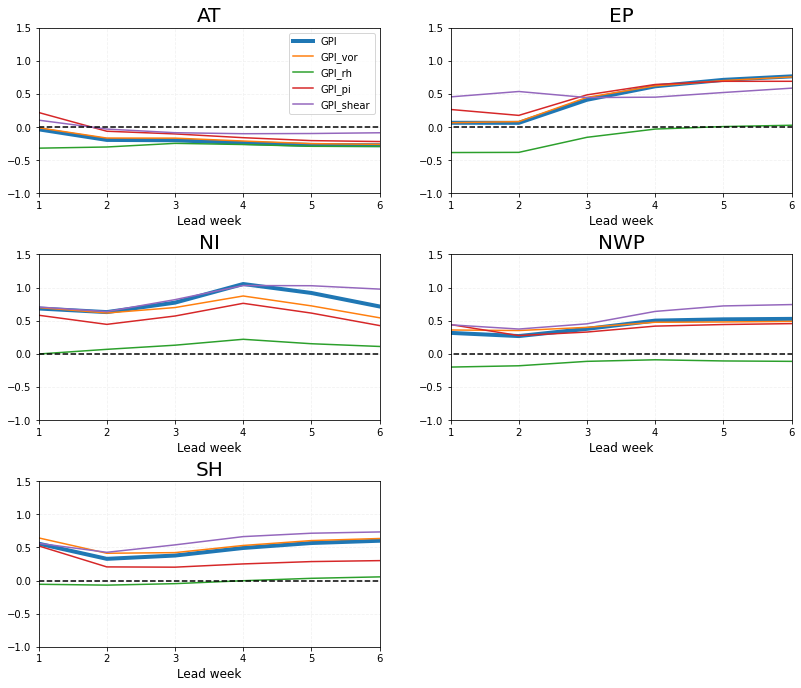

In [70]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.tight_layout(pad=4)
basin_str=['AT','EP','NI','NWP','SH']
axs = axs.flatten()

for ib in np.arange(0,5):
    (get_gpi_basin(gpi_month_diff, ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI',linewidth=4)
    (get_gpi_basin(gpi_vor_diff,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_vor')
    (get_gpi_basin(gpi_rh_diff,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_rh')
    (get_gpi_basin(gpi_pi_diff,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_pi')
    (get_gpi_basin(gpi_shear_diff,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_shear')

    axs[ib].plot(np.arange(0,8),np.zeros(8),color='black',linestyle='--')
    axs[ib].set_ylim(-1., 1.5)
    axs[ib].grid(color='0.95', linestyle='--')
    axs[ib].set_xlim(1,6)
    
#    axs[ib].set_ylabel("Brier Skill Score",fontsize=12)
    axs[ib].set_xlabel("Lead week",fontsize=12)
    axs[ib].set_title(basin_str[ib],fontsize=20)
    axs[ib].set_xticks(np.arange(1, 7))

axs[-1].axis('off')

# plt.subplots_adjust(top=0.85)
axs[0].legend()


**note**:
This figure above shows difference between the modified GPI and the observations. the value itself shows how each GPI term compared to the observataioms. compare the results to gpi_diff (blue) shows how different factors affect the GPI. blue minus other shows how each term affects the GPI in the model. the changes between leads small -> that terms determines the changes between leads. 

AT: GPI is small than observed in week1-week6. Replacing pi with the observed in week1 makes the GPI better (PI in the model makes the genesis worse for week1).the differnce between leads is because of shear and RH. 

EP: GPI is actually better than observed, and it gets better with lead time. observed shear would make it better (model shear is detrimental); replacing with observed RH would make it worse (model relative humidity is good for GPI). The differeces between leads is because of the changes of VWS 

NI: the condition is better for TCs than in observations. all factors increases over time, week4 is the best because shear makes it worse for week5-6. 

NWP: all factors exacept for the RH made the GPI better than observed. the lowest is week2 and then increases and stays the same for 5-6. model shear made it worse for week 4-6. The vorticity and RH GPI  is relatively flat, meaning that it may controls the changes over lead. 

SH: GPI is geenerally higher than observed. RH and PI are the main factors that made the GPI gets higher during week 2-6. 

### 5.2 replace all terms but one to the observd:

In [71]:
# now get gpi with observational terms
gpi_vor_o = (t_rh_o * t_vor  * t_pi_o * t_shear_o).rename('gpi_vor')
gpi_rh_o  = (t_vor_o * t_rh * t_pi_o * t_shear_o).rename('gpi_rh')
gpi_pi_o = (t_vor_o * t_rh_o * t_pi * t_shear_o).rename('gpi_pi')
gpi_shear_o = (t_vor_o * t_rh_o * t_pi_o * t_shear).rename('gpi_shear')

In [72]:
gpi_vor_diffo =  gpi_vor_o - gpi_jra_regrid
gpi_rh_diffo = gpi_rh_o - gpi_jra_regrid
gpi_pi_diffo = gpi_pi_o - gpi_jra_regrid
gpi_shear_diffo = gpi_shear_o - gpi_jra_regrid

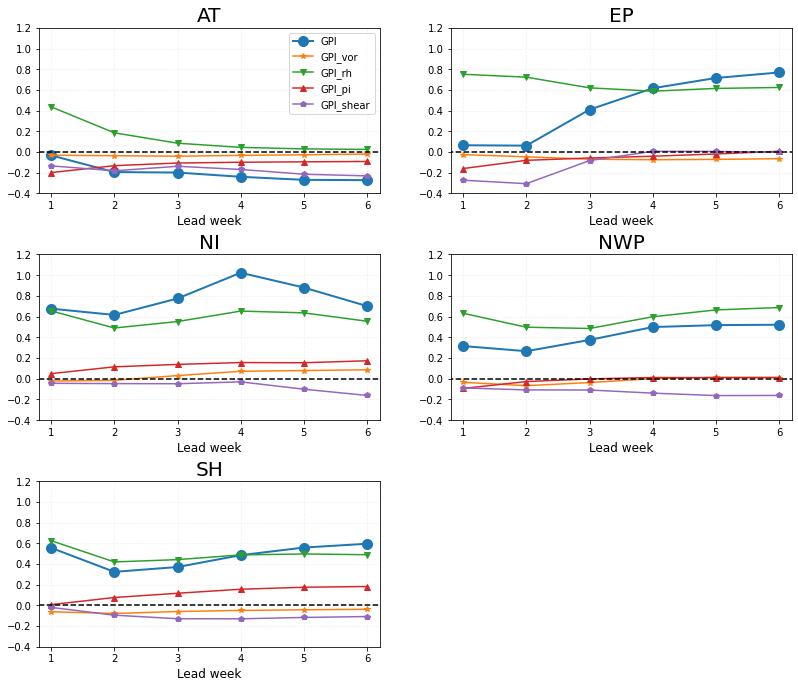

In [84]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.tight_layout(pad=4)
basin_str=['AT','EP','NI','NWP','SH']
axs = axs.flatten()

for ib in np.arange(0,5):
    (get_gpi_basin(gpi_month_diff, ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI',linewidth=2, linestyle='-', marker='o',markersize=10)
    (get_gpi_basin(gpi_vor_diffo,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_vor',linestyle='-', marker='*')
    (get_gpi_basin(gpi_rh_diffo,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_rh',linestyle='-', marker='v')
    (get_gpi_basin(gpi_pi_diffo,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_pi',linestyle='-', marker='^')
    (get_gpi_basin(gpi_shear_diffo,ib).mean('member')/get_gpi_basin(gpi_jra_regrid,ib)).plot(ax=axs[ib],label='GPI_shear',linestyle='-', marker='p')

    axs[ib].plot(np.arange(0,8),np.zeros(8),color='black',linestyle='--')
    axs[ib].set_ylim(-.4, 1.2)
    axs[ib].grid(color='0.95', linestyle='--')
    axs[ib].set_xlim(0.8,6.2)
    
#    axs[ib].set_ylabel("Brier Skill Score",fontsize=12)
    axs[ib].set_xlabel("Lead week",fontsize=12)
    axs[ib].set_title(basin_str[ib],fontsize=20)
    axs[ib].set_xticks(np.arange(1, 7))

axs[-1].axis('off')

# plt.subplots_adjust(top=0.85)
axs[0].legend()

plt.savefig('GPI_anom_bylead.pdf')

In [85]:
gpi_month_diff

<xarray.DataArray 'gpi' (week: 6, month: 12, member: 10, lat: 192, lon: 288)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev_p      float64 700.0
  * week       (week) int64 1 2 3 4 5 6
    number     int64 0
    step       timedelta64[ns] 00:00:00
    latitude   (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    longitude  (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

No handles with labels found to put in legend.


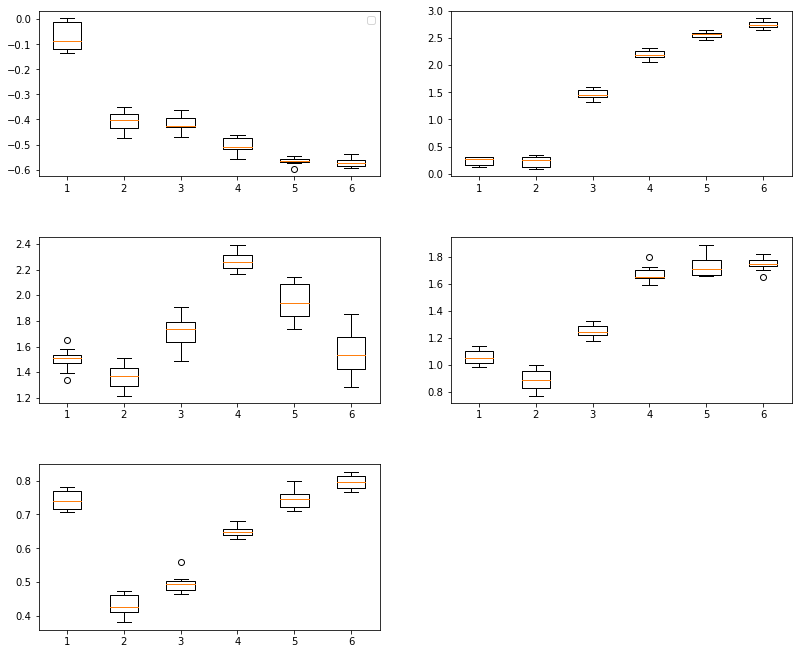

In [90]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.tight_layout(pad=4)
basin_str=['AT','EP','NI','NWP','SH']
axs = axs.flatten()

for ib in np.arange(0,5):
    axs[ib].boxplot(get_gpi_basin(gpi_month_diff, ib).transpose('member','week'))
    



axs[-1].axis('off')

# plt.subplots_adjust(top=0.85)
axs[0].legend()



This spread represents the spread of member climatology. long-term climatology conditionsn affect member spread. 

AT: replacing observed with modeled RH increases GPI in week1-3. all other terms make the GPI worse. Again, RH and shearalso determines the changes over lead. 

EP: replacing observations with modeled RH incrreases in all weeks, VWS and pi are detrimental. but the VWS is the determinning facotr in differences across leads. 

NI:PI, vor, RH made the model better, shear made it worse. VWS and RH made the differences between leads. 

NWP: RH made it better, shear made it worse in week 3-6. from week1 to week2, VWS, vort and RH all contribute to the week2 dent.RH and PI made it increase from week2 to week6. 

SH: RH, PI made it better, shear, vor made it worse. week2 dent is because of VWS, vort and RH, increase from week2 is because of PI AND RH. 

Here, the comparisons are between modified GPI and the original S2S GPI. So the differences inidicate the changes 

### 5.3 pattern of modified GPI

In [76]:
# difference between gpi_vor and gpi 
# difference between gpi_vor week2 and gpi_vor week1, when vorticity is the same, difference between the two

gpi_vor_summer_diff = gpi_vor_summer - gpi_summer
gpi_vor_winter_diff = gpi_vor_winter - gpi_winter

gpi_rh_summer_diff = gpi_rh_summer - gpi_summer
gpi_rh_winter_diff = gpi_rh_winter- gpi_winter

gpi_pi_summer_diff = gpi_pi_summer - gpi_summer
gpi_pi_winter_diff = gpi_pi_winter - gpi_winter

gpi_shear_summer_diff = gpi_shear_summer - gpi_summer
gpi_shear_winter_diff = gpi_shear_winter- gpi_winter

In [104]:
#gpi_summer_diffm = gpi_summer_diff.copy(data=gpi_summer_diff.data - gpi_summer_diff.isel(week=0).data)
#gpi_winter_diffm = gpi_winter_diff.copy(data=gpi_winter_diff.data - gpi_winter_diff.isel(week=0).data)

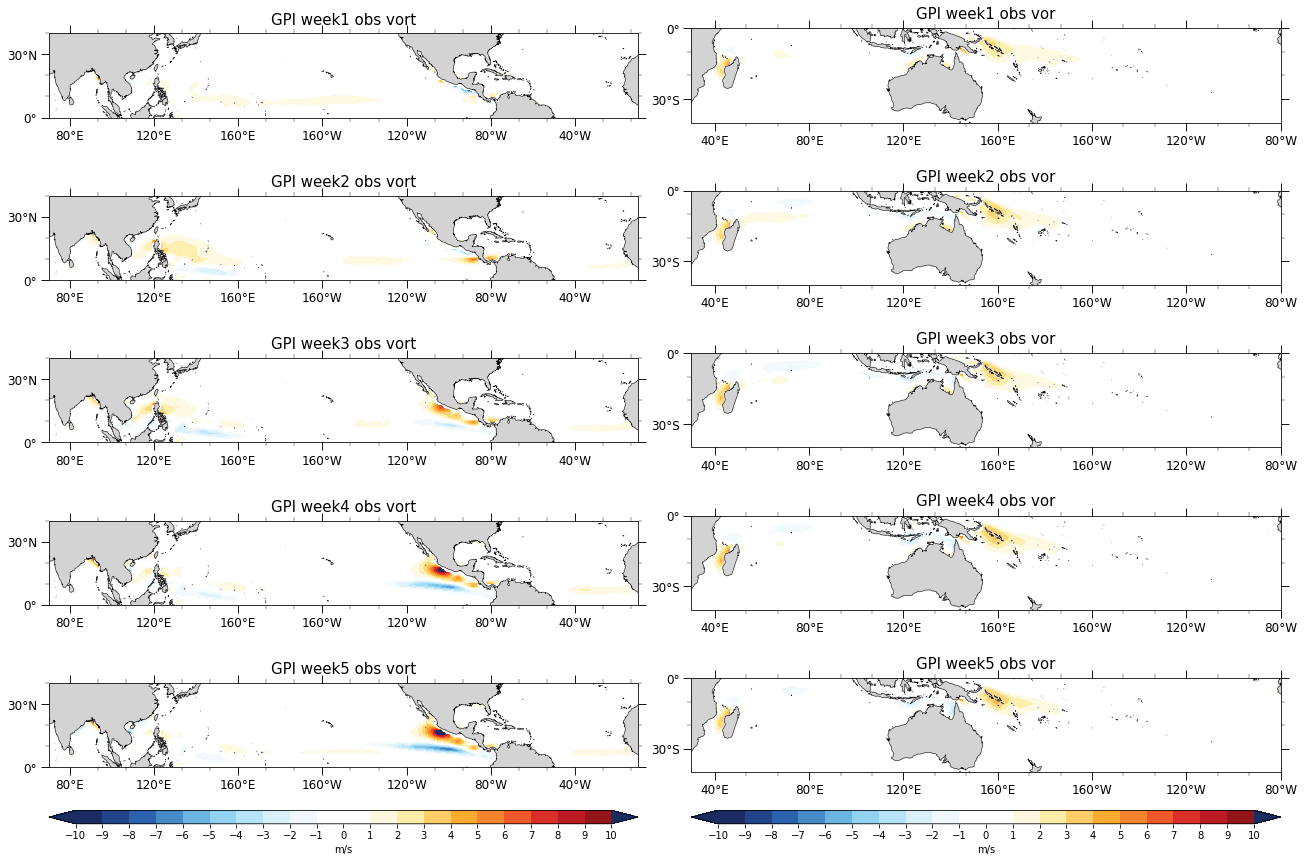

In [77]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_vor_summer_diff.mean('member')[i],i,0,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" obs vort", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_vor_winter_diff.mean('member')[i],i,1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i+1).astype(str)+" obs vor", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




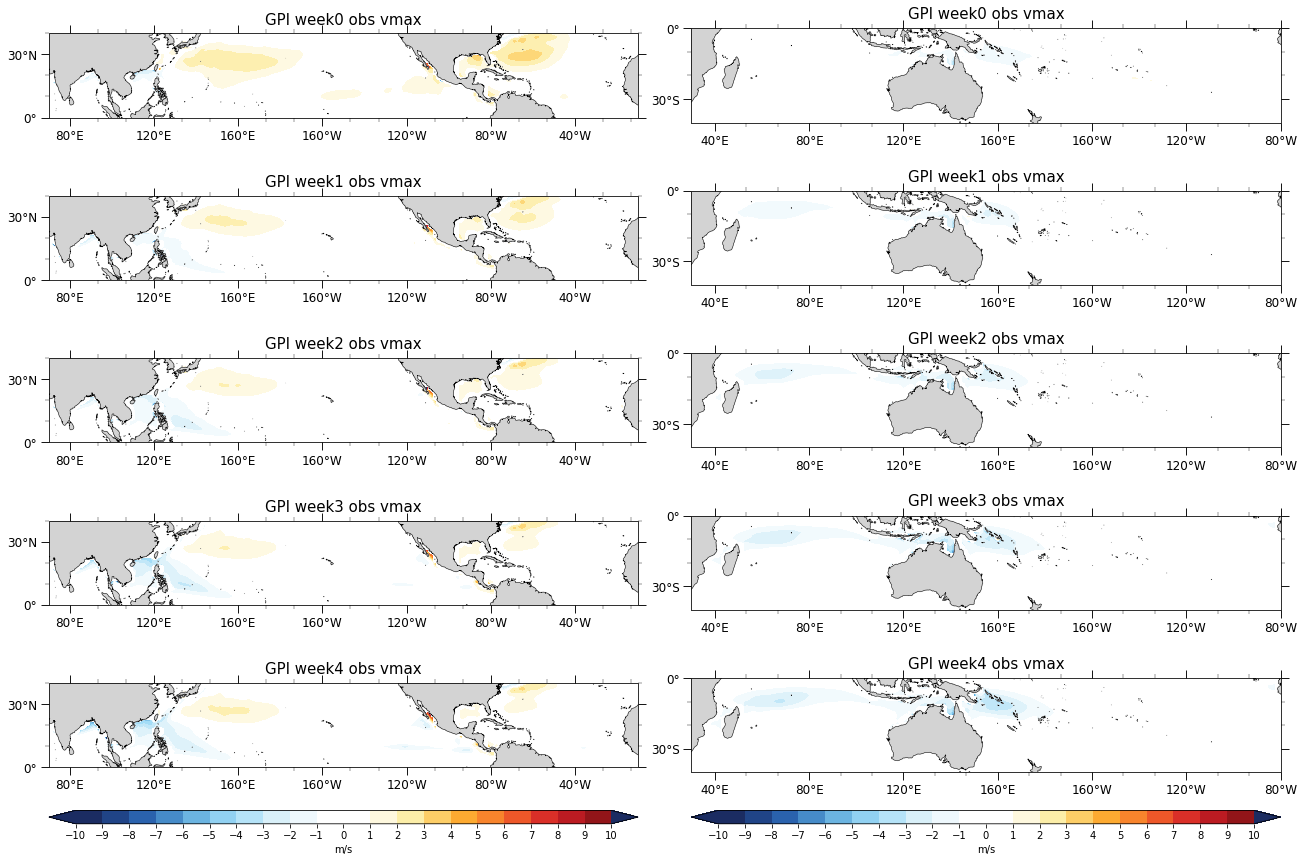

In [79]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_pi_summer_diff.mean('member')[i],i,0,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs vmax", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_pi_winter_diff.mean('member')[i],i,1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs vmax", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




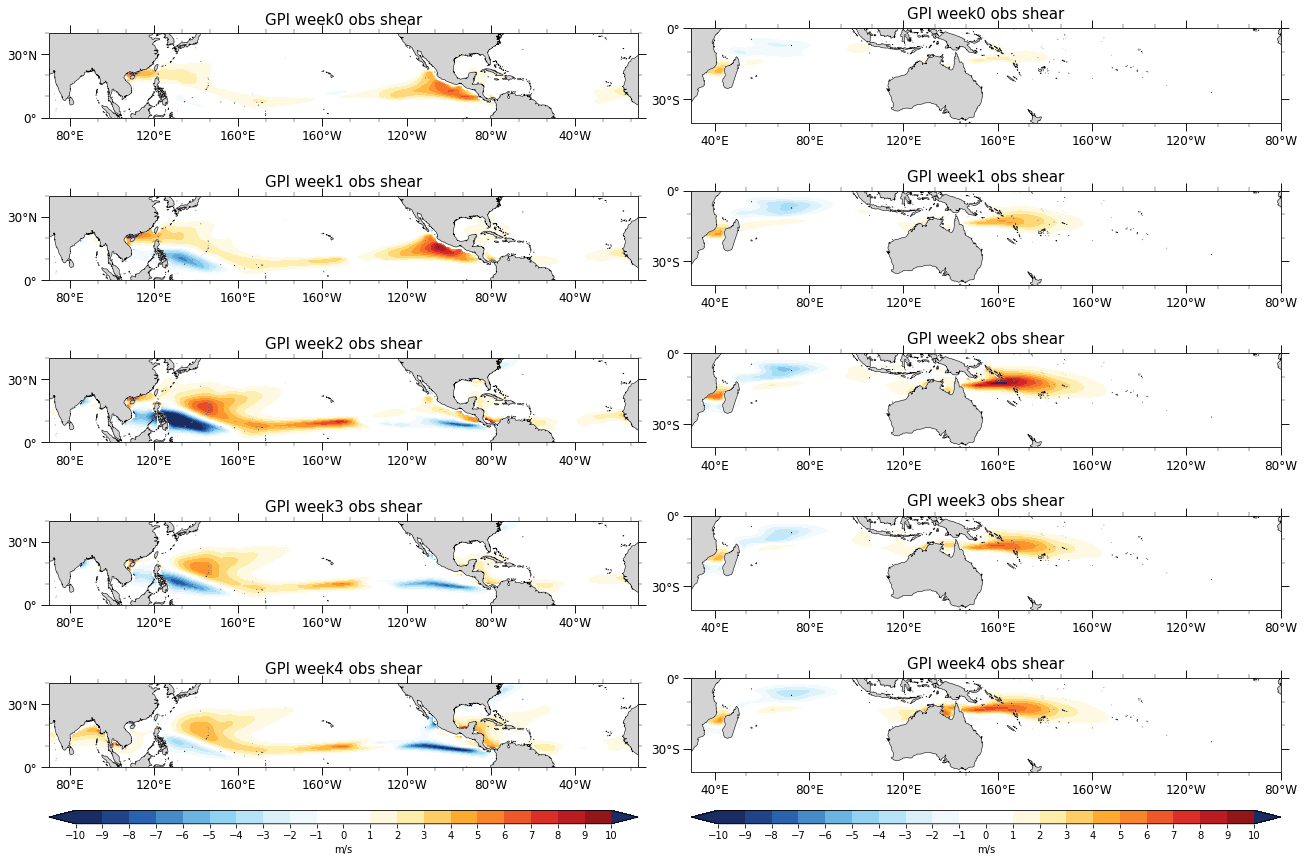

In [503]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_shear_summer_diff[i],i,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs shear", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_shear_winter_diff[i],i,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs shear", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




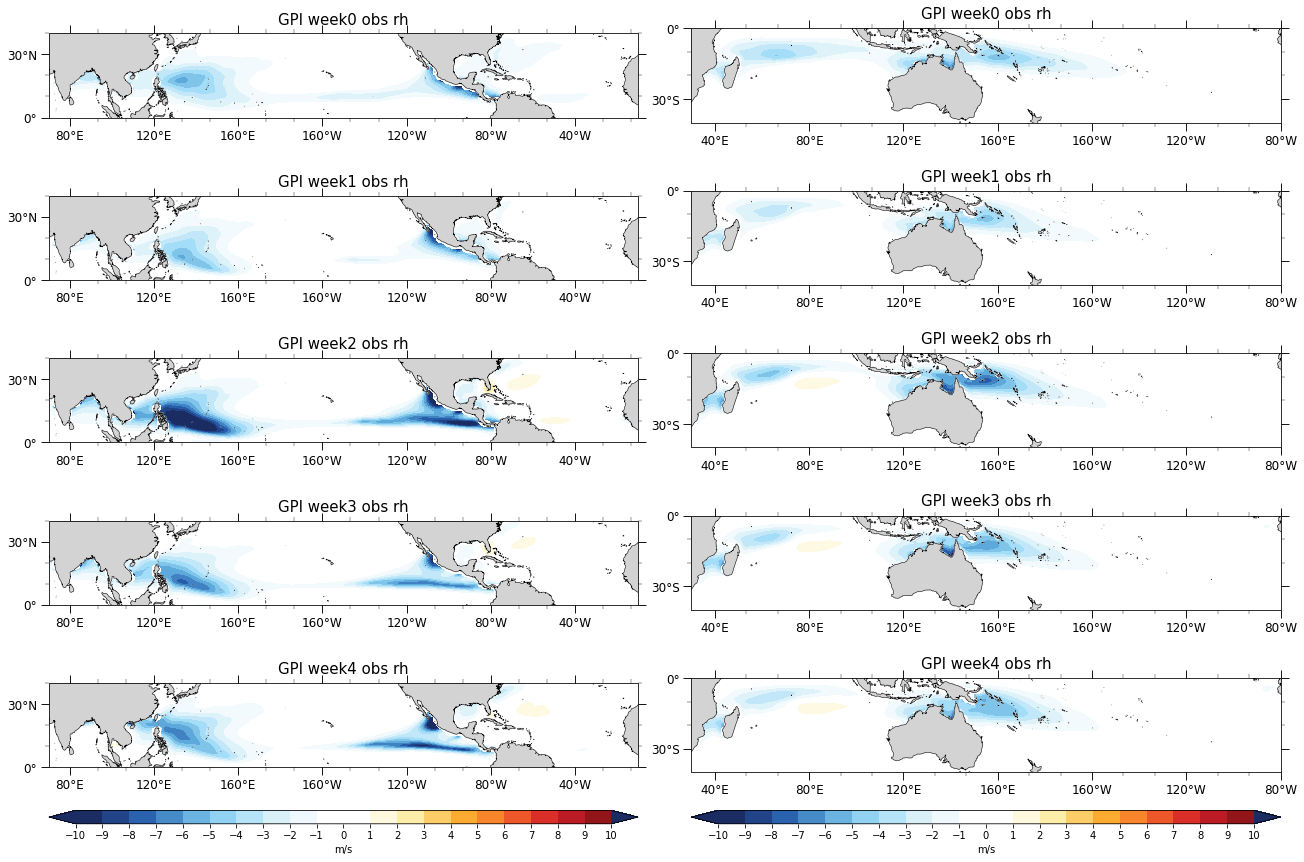

In [504]:
levels=np.linspace(1,12,13)
levels2 =np.linspace(-10,10,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1,  1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)


for i in np.arange(0,5):
    var_plot_panels(gpi_rh_summer_diff[i],i,0,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs rh", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter

for i in np.arange(0,5):
    var_plot_panels_winter(gpi_rh_winter_diff[i],i,1,ax1,levels2,gvcmaps.BlueWhiteOrangeRed,"GPI week"+(i).astype(str)+" obs rh", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')




### GPI box whisker plot, showing TC seasonal GPI across forecast lead with error bars

## get nino 3.4 time series

In [2]:
r=pd.read_fwf('nino34.long.data', header=None)

In [3]:
dates = pd.date_range('2002',periods=18,freq='1Y')

In [4]:
dates.year

Int64Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64')

In [5]:
r = r.set_axis(dates.year, axis='index')

r = r.set_axis(np.arange(0,13),axis='columns')

r = r.transpose()

In [6]:
nino34 = []
for iy in np.arange(2002,2020):
    nino34.append(r[iy][1:13].array.to_numpy())

In [58]:
nino34

[array([26.44, 26.76, 27.36, 27.91, 28.07, 28.37, 27.8 , 27.57, 27.57,
        27.89, 28.06, 28.  ]),
 array([27.56, 27.4 , 27.74, 27.74, 27.34, 27.5 , 27.37, 26.92, 26.9 ,
        27.19, 27.05, 26.91]),
 array([26.84, 26.93, 27.16, 27.83, 27.96, 27.82, 27.64, 27.54, 27.42,
        27.46, 27.27, 27.3 ]),
 array([27.14, 27.02, 27.54, 28.05, 28.16, 27.91, 27.22, 26.83, 26.67,
        26.59, 26.21, 25.83]),
 array([25.6 , 26.05, 26.53, 27.47, 27.76, 27.78, 27.25, 27.25, 27.38,
        27.49, 27.64, 27.69]),
 array([27.17, 26.88, 27.11, 27.61, 27.47, 27.52, 26.86, 26.31, 25.71,
        25.33, 25.07, 24.98]),
 array([24.79, 25.07, 26.09, 26.88, 27.22, 27.24, 27.19, 26.83, 26.47,
        26.43, 26.29, 25.69]),
 array([25.58, 26.05, 26.54, 27.52, 28.04, 28.17, 27.91, 27.49, 27.43,
        27.69, 28.15, 28.4 ]),
 array([28.  , 27.94, 28.33, 28.33, 27.72, 27.07, 26.34, 25.55, 25.19,
        25.08, 25.08, 24.95]),
 array([24.88, 25.5 , 26.27, 27.03, 27.34, 27.43, 27.  , 26.22, 25.99,
        25.

In [7]:
ninoarray = xr.DataArray(nino34,dims=['year','month'])

In [8]:
stacked = ninoarray.stack(time=('year','month'))

In [9]:
stacked

<xarray.DataArray (time: 216)>
array([26.44, 26.76, 27.36, 27.91, 28.07, 28.37, 27.8 , 27.57, 27.57,
       27.89, 28.06, 28.  , 27.56, 27.4 , 27.74, 27.74, 27.34, 27.5 ,
       27.37, 26.92, 26.9 , 27.19, 27.05, 26.91, 26.84, 26.93, 27.16,
       27.83, 27.96, 27.82, 27.64, 27.54, 27.42, 27.46, 27.27, 27.3 ,
       27.14, 27.02, 27.54, 28.05, 28.16, 27.91, 27.22, 26.83, 26.67,
       26.59, 26.21, 25.83, 25.6 , 26.05, 26.53, 27.47, 27.76, 27.78,
       27.25, 27.25, 27.38, 27.49, 27.64, 27.69, 27.17, 26.88, 27.11,
       27.61, 27.47, 27.52, 26.86, 26.31, 25.71, 25.33, 25.07, 24.98,
       24.79, 25.07, 26.09, 26.88, 27.22, 27.24, 27.19, 26.83, 26.47,
       26.43, 26.29, 25.69, 25.58, 26.05, 26.54, 27.52, 28.04, 28.17,
       27.91, 27.49, 27.43, 27.69, 28.15, 28.4 , 28.  , 27.94, 28.33,
       28.33, 27.72, 27.07, 26.34, 25.55, 25.19, 25.08, 25.08, 24.95,
       24.88, 25.5 , 26.27, 27.03, 27.34, 27.43, 27.  , 26.22, 25.99,
       25.81, 25.56, 25.54, 25.65, 26.15, 26.78, 27.48, 27.69, 27.82,
       27.66, 27.54, 27.19, 26.96, 26.98, 26.45, 26.16, 26.36, 27.12,
       27.69, 27.59, 27.36, 26.94, 26.59, 26.66, 26.49, 26.64, 26.5 ,
       26.16, 26.31, 27.19, 28.05, 28.32, 28.16, 27.36, 27.02, 27.12,
       27.22, 27.54, 27.36, 27.17, 27.34, 27.73, 28.67, 28.9 , 28.96,
       28.78, 28.75, 28.76, 28.94, 29.23, 29.14, 29.14, 28.87, 28.86,
       28.82, 28.32, 27.75, 26.97, 26.4 , 26.29, 25.99, 26.02, 26.07,
       26.24, 26.75, 27.17, 27.99, 28.17, 27.91, 27.44, 26.69, 26.2 ,
       26.21, 25.81, 25.74, 25.72, 26.03, 26.53, 27.41, 27.75, 27.81,
       27.49, 26.93, 27.05, 27.57, 27.65, 27.56, 27.09, 27.38, 28.06,
       28.44, 28.48, 28.34, 27.64, 27.07, 26.86, 27.29, 27.39, 27.1 ])
Coordinates:
  * time     (time) MultiIndex
  - year     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 17 17 17 17 17 17 17 17 17 17
  - month    (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11

In [10]:
stacked['time'] = pd.date_range('20020101','20191231',freq='1M')

In [11]:
stacked.name = 'nino34'

In [12]:
stacked = (stacked -  stacked.mean('time'))

In [25]:
stacked_rollilng = stacked.rolling(time=5).mean()

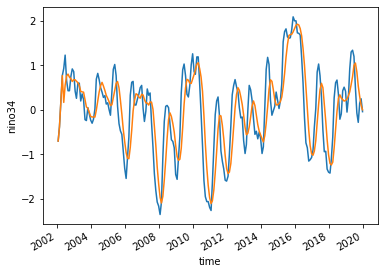

In [29]:
stacked.plot()
stacked_rollilng.plot()

In [27]:
stacked_rollilng = xr.where(np.isnan(stacked_rollilng), stacked, stacked_rollilng)

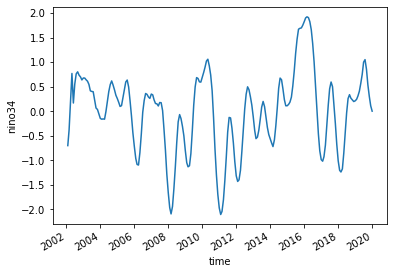

In [28]:
stacked_rollilng.plot()

In [30]:
stacked_rollilng.to_dataset().to_netcdf('nino34_series_2002-2019.nc')

In [69]:
r2 =pd.read_fwf('amo_monthly.10yrLP.txt', header=None)
r2

0     1     2     3     4     5     6     7     8     9     10    11  \
0   2002  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.10  0.10  0.10   
1   2003  0.11  0.11  0.12  0.12  0.12  0.12  0.12  0.12  0.12  0.12  0.12   
2   2004  0.12  0.12  0.11  0.11  0.11  0.11  0.11  0.10  0.10  0.10  0.10   
3   2005  0.10  0.10  0.10  0.10  0.10  0.10  0.11  0.11  0.11  0.11  0.12   
4   2006  0.12  0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.13   
5   2007  0.13  0.13  0.13  0.13  0.13  0.14  0.14  0.15  0.15  0.15  0.15   
6   2008  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16   
7   2009  0.16  0.16  0.16  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15   
8   2010  0.15  0.15  0.14  0.14  0.14  0.13  0.13  0.12  0.12  0.12  0.12   
9   2011  0.11  0.11  0.11  0.10  0.10  0.10  0.10  0.10  0.10  0.09  0.09   
10  2012  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09  0.09   
11  2013  0.09  0.09  0.09  0.08  0.08  0.08  0.07  0.07  0.07  0.07  0.06   
12  2014  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06   
13  2015  0.06  0.07  0.07  0.07  0.06  0.06  0.06  0.06  0.06  0.05  0.05   

      12  
0   0.11  
1   0.12  
2   0.10  
3   0.12  
4   0.13  
5   0.16  
6   0.16  
7   0.15  
8   0.11  
9   0.09  
10  0.09  
11  0.06  
12  0.06  
13  0.05

In [70]:
dates = pd.date_range('2002',periods=14,freq='1Y')
dates.year

Int64Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015],
           dtype='int64')

In [71]:
r2 = r2.set_axis(dates.year, axis='index')
r2 = r2.set_axis(np.arange(0,13),axis='columns')
r2 = r2.transpose()

In [72]:
r2

2002     2003     2004     2005     2006     2007     2008     2009  \
0   2002.00  2003.00  2004.00  2005.00  2006.00  2007.00  2008.00  2009.00   
1      0.09     0.11     0.12     0.10     0.12     0.13     0.16     0.16   
2      0.09     0.11     0.12     0.10     0.13     0.13     0.16     0.16   
3      0.09     0.12     0.11     0.10     0.13     0.13     0.16     0.16   
4      0.09     0.12     0.11     0.10     0.13     0.13     0.16     0.15   
5      0.09     0.12     0.11     0.10     0.13     0.13     0.16     0.15   
6      0.09     0.12     0.11     0.10     0.13     0.14     0.16     0.15   
7      0.09     0.12     0.11     0.11     0.13     0.14     0.16     0.15   
8      0.09     0.12     0.10     0.11     0.13     0.15     0.16     0.15   
9      0.10     0.12     0.10     0.11     0.13     0.15     0.16     0.15   
10     0.10     0.12     0.10     0.11     0.13     0.15     0.16     0.15   
11     0.10     0.12     0.10     0.12     0.13     0.15     0.16     0.15   
12     0.11     0.12     0.10     0.12     0.13     0.16     0.16     0.15   

       2010     2011     2012     2013     2014     2015  
0   2010.00  2011.00  2012.00  2013.00  2014.00  2015.00  
1      0.15     0.11     0.09     0.09     0.06     0.06  
2      0.15     0.11     0.09     0.09     0.06     0.07  
3      0.14     0.11     0.09     0.09     0.06     0.07  
4      0.14     0.10     0.09     0.08     0.06     0.07  
5      0.14     0.10     0.09     0.08     0.06     0.06  
6      0.13     0.10     0.09     0.08     0.06     0.06  
7      0.13     0.10     0.09     0.07     0.06     0.06  
8      0.12     0.10     0.09     0.07     0.06     0.06  
9      0.12     0.10     0.09     0.07     0.06     0.06  
10     0.12     0.09     0.09     0.07     0.06     0.05  
11     0.12     0.09     0.09     0.06     0.06     0.05  
12     0.11     0.09     0.09     0.06     0.06     0.05

In [73]:
amo = []
for iy in np.arange(2002,2016):
    amo.append(r2[iy][1:13].array.to_numpy())

In [75]:
amoarray = xr.DataArray(amo,dims=['year','month'])

In [76]:
stacked = amoarray.stack(time=('year','month'))

In [77]:
stacked

<xarray.DataArray (time: 168)>
array([0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.1 , 0.1 , 0.1 ,
       0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12,
       0.12, 0.12, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11, 0.11, 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.11, 0.11,
       0.11, 0.11, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13,
       0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14,
       0.14, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.14,
       0.14, 0.14, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12, 0.11, 0.11, 0.11,
       0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.09, 0.09, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 0.07, 0.06,
       0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
       0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.06,
       0.05, 0.05, 0.05])
Coordinates:
  * time     (time) MultiIndex
  - year     (time) int64 0 0 0 0 0 0 0 0 0 0 ... 13 13 13 13 13 13 13 13 13 13
  - month    (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11

In [78]:
stacked['time'] = pd.date_range('20020101','20151231',freq='1M')

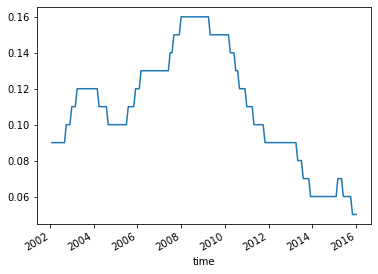

In [79]:
stacked.plot()

In [261]:
nino34_rolling_mean = stacked.rolling(time=5).mean()

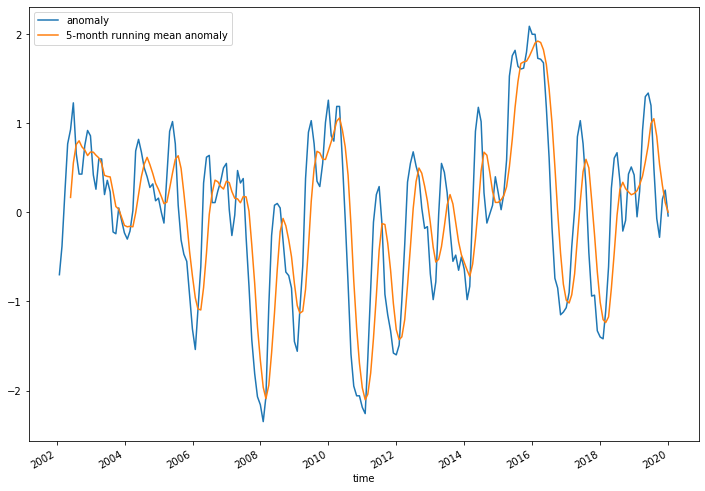

In [262]:
stacked.plot(size=8)
nino34_rolling_mean.plot()
plt.legend(['anomaly', '5-month running mean anomaly']);

In [263]:
std_dev = stacked.std()

In [264]:
std_dev

<xarray.DataArray ()>
array(0.93163875)

In [265]:
n_nino34_rolling_mean = nino34_rolling_mean / std_dev

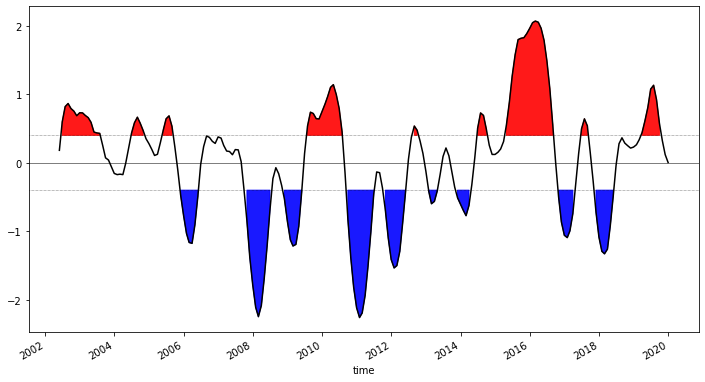

In [266]:
fig = plt.figure(figsize=(12, 6))

# Add -0.4/+0.4 lines which are the El Niño 3.4 thresholds
plt.fill_between(
    n_nino34_rolling_mean.time.data,
    n_nino34_rolling_mean.where(n_nino34_rolling_mean >= 0.4).data,
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    n_nino34_rolling_mean.time.data,
    n_nino34_rolling_mean.where(n_nino34_rolling_mean <= -0.4).data,
    -0.4,
    color='blue',
    alpha=0.9,
)

n_nino34_rolling_mean.plot(color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted');